In [ ]:
from google.colab import drive
from os import walk
import os

drive.mount("/content/drive", force_remount=True)

path = '/content/drive/My Drive/Fresh_and_Stale_medium'

Mounted at /content/drive


**Analysing Class distribution of image dataset**

In [ ]:
image_dict = {}

from pathlib import Path
from tqdm import tqdm
import pandas as pd
import os

file_names = []
labels = []

for file in sorted((Path(path).glob('*/*.*'))):
    label = str(file).split('/')[-2]  #class name from  path
    labels.append(label)
    file_names.append(str(file))  # Add the file path to the list

print(len(file_names), len(labels))

df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

7038 7038
(7038, 2)


In [ ]:
df_label=df['label'].value_counts().to_frame().reset_index()
df_label

,index,label
0,fresh_apple,1693
1,fresh_banana,1581
2,fresh_orange,1466
3,fresh_capsicum,990
4,fresh_tomato,981
5,fresh_bitter_gourd,327


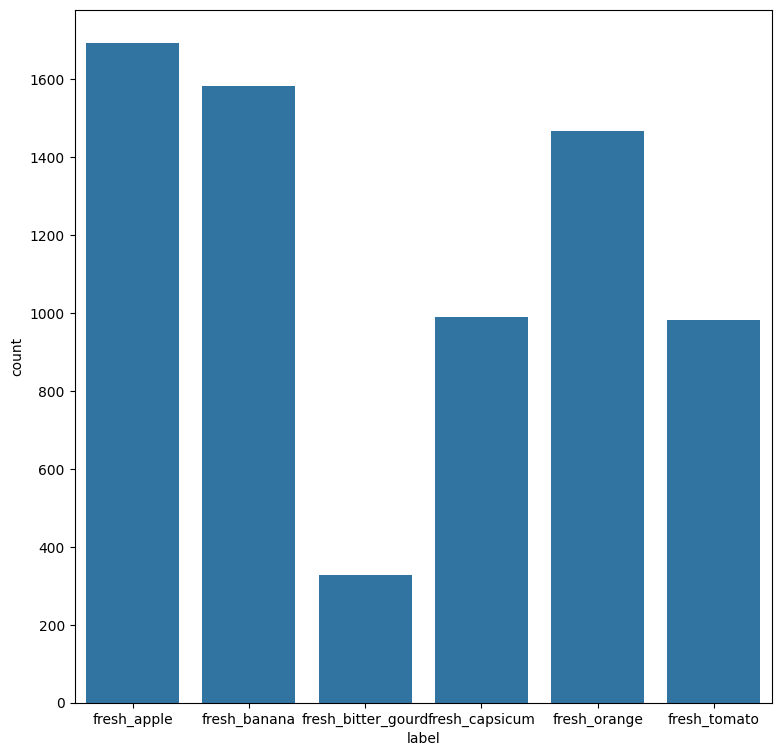

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.countplot(x=df['label'])
plt.show()

**PyTorch to load image dataset, pre-processing using transformations and training model**

In [ ]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder

#Defining tranforms for dataset
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

dataset = ImageFolder(path, transform=transform)

dataset.class_to_idx

{'fresh_apple': 0,
 'fresh_banana': 1,
 'fresh_bitter_gourd': 2,
 'fresh_capsicum': 3,
 'fresh_orange': 4,
 'fresh_tomato': 5}

In [ ]:
from collections import Counter

counts = dict(Counter(dataset.targets))
counts.values()


dict_values([1693, 1581, 327, 990, 1466, 981])

In [ ]:
#Split into training, testing and validation set
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))

test_size = int(0.1 * len(dataset))

val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

In [ ]:
print("Training set size: ", len(train_dataset))
print("Testing set size: ", len(test_dataset))
print("Validation set size: ", len(val_dataset))

Training set size:  5630
Testing set size:  703
Validation set size:  705


In [ ]:
import torch
train_dataset.targets = torch.tensor([train_dataset.dataset.targets[i] for i in train_dataset.indices]).numpy().tolist()
train_dataset.label = torch.tensor([train_dataset.dataset.samples[i][1] for i in train_dataset.indices]).numpy().tolist()

In [ ]:
print(dict(Counter(train_dataset.targets)))

{1: 1252, 4: 1168, 5: 799, 0: 1368, 3: 792, 2: 251}


In [ ]:
#Removing class imbalance using Weighted Random Sampler

dict_ = {"fresh_apple": 0, "fresh_banana": 1, "fresh_orange": 2, "fresh_capsicum": 3, "fresh_tomato": 4, "fresh_bitter_gourd": 5}

class_counts = torch.tensor([train_dataset.targets.count(c) for c in [0, 1, 2, 3, 4, 5]])
print(class_counts)
class_weights = 1.0 / class_counts.double()
print(class_weights)

weights = [class_weights[target] for target in train_dataset.label]
print(len(weights))
sample_weights = torch.DoubleTensor(weights)
print(sample_weights)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

tensor([1368, 1252,  251,  792, 1168,  799])
tensor([0.0007, 0.0008, 0.0040, 0.0013, 0.0009, 0.0013], dtype=torch.float64)
5630
tensor([0.0008, 0.0009, 0.0013,  ..., 0.0007, 0.0013, 0.0007],
       dtype=torch.float64)


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler = sampler, batch_size = 64, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, num_workers=2)

In [ ]:
from torchvision import models

model=models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model.named_parameters

<bound method Module.named_parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1),

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


In [ ]:
from tqdm.notebook import tqdm_notebook

def train(model,num_epochs,train_dl,valid_dl,train_data_percent,model_name):
    model.to(device)
    max_acc=0.0
    torch.save(model.state_dict(),f"best_weights_of_{model_name}.pt")
    loss_hist_train=[0]*num_epochs
    accuracy_hist_train=[0]*num_epochs
    loss_hist_valid=[0]*num_epochs
    accuracy_hist_valid=[0]*num_epochs
    no_of_batches_to_train=int(round(len(train_dl)*train_data_percent))
    for epoch in tqdm_notebook(range(num_epochs),desc="Number of Epochs Completed"):
        model.train()
        count=0
        for x_batch,y_batch in tqdm_notebook(train_dl,desc="Number of Training Batches Completed"):
            if train_data_percent!=1 and count>no_of_batches_to_train:
                break
            count+=1
            x_batch,y_batch=x_batch.to(device),y_batch.to(device)
            pred=model(x_batch)
            loss=loss_fn(pred,y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch]+=loss.item()*y_batch.size(0)
            is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
            accuracy_hist_train[epoch]+=is_correct.sum()
        loss_hist_train[epoch]/=len(train_dl.dataset)
        accuracy_hist_train[epoch]/=len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch,y_batch in tqdm_notebook(valid_dl,desc="Number of Validation Batches Completed"):
                x_batch,y_batch=x_batch.to(device),y_batch.to(device)
                pred=model(x_batch)
                loss=loss_fn(pred,y_batch)
                loss_hist_valid[epoch]+=loss.item()*y_batch.size(0)
                is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
                accuracy_hist_valid[epoch]+=is_correct.sum()
            loss_hist_valid[epoch]/=len(valid_dl.dataset)
            accuracy_hist_valid[epoch]/=len(valid_dl.dataset)
        if accuracy_hist_valid[epoch]>max_acc:
            max_acc=accuracy_hist_valid[epoch]
            torch.save(model.state_dict(),f"best_weights_of_{model_name}.pt")
        print(f'Epoch {epoch+1} accuracy: '
               f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
               f'{accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid



In [ ]:
num_epochs=10
hist=train(model,num_epochs,train_dataloader,val_dataloader,0.2,"model_resnet")

Number of Epochs Completed:   0%|          | 0/10 [00:00<?, ?it/s]

Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 accuracy: 0.1018 val_accuracy: 0.2965


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 accuracy: 0.1412 val_accuracy: 0.4596


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 accuracy: 0.1501 val_accuracy: 0.7645


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 accuracy: 0.1641 val_accuracy: 0.8057


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 accuracy: 0.1673 val_accuracy: 0.8340


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6 accuracy: 0.1789 val_accuracy: 0.8355


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7 accuracy: 0.1728 val_accuracy: 0.8397


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8 accuracy: 0.1899 val_accuracy: 0.7106


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9 accuracy: 0.1940 val_accuracy: 0.9021


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10 accuracy: 0.1945 val_accuracy: 0.9262


In [ ]:
import pickle

# Save the model to a pickle file
with open('model_resnet_medium.pkl', 'wb') as file:
    pickle.dump(model, file)


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Test the model
y_true, y_pred = test_model(model, test_dataloader)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[149   9   0   1   5   7]
 [  6 152   2   0   3   0]
 [  0   0  32   0   0   0]
 [  0   0   7  91   0   2]
 [  3   0   0   3 137   1]
 [  0   0   1   0   0  92]]


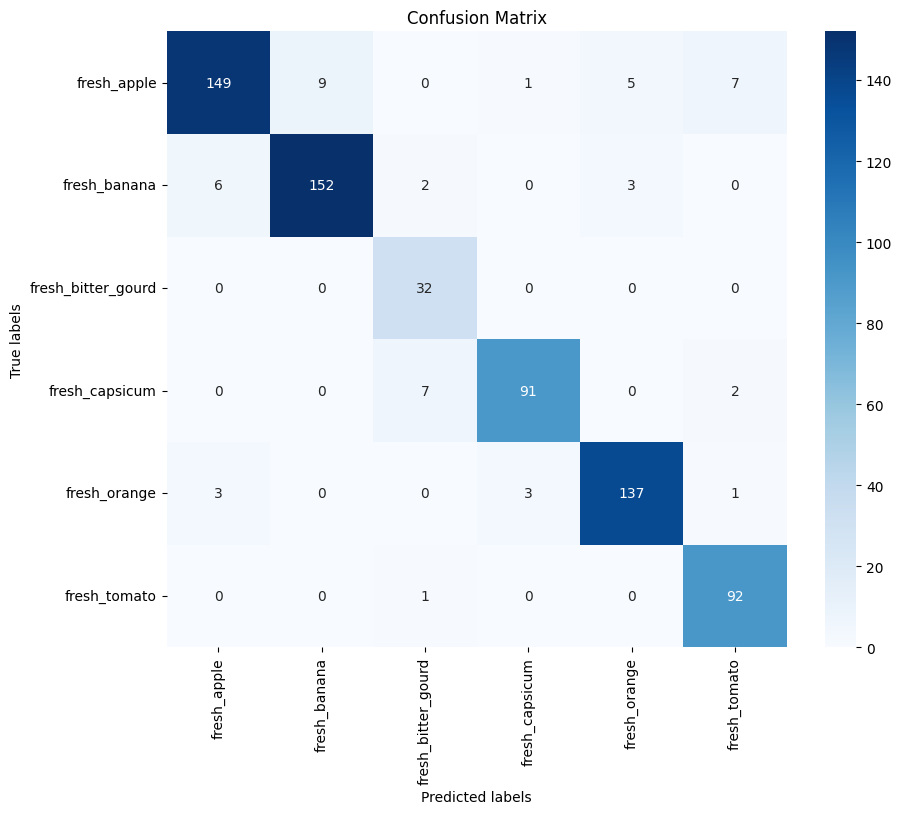

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
train_accuracies = []
test_accuracies = []
for i in range(len(hist[2])):
    if device.type == 'cuda':
      train_accuracies.append(hist[2][i].cpu().numpy().tolist())
      test_accuracies.append(hist[3][i].cpu().numpy().tolist())
    else:
      train_accuracies.append(hist[2][i].numpy().tolist())
      test_accuracies.append(hist[3][i].numpy().tolist())


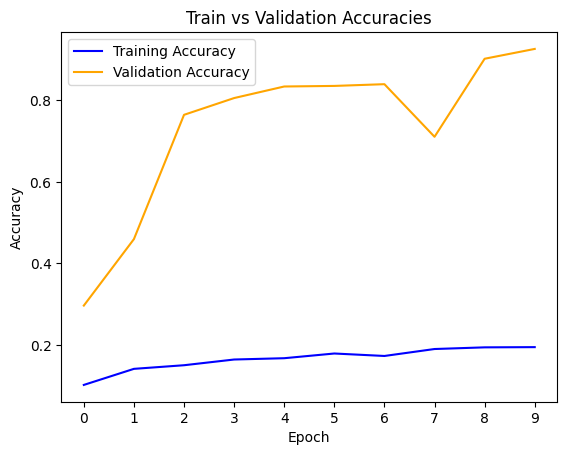

In [ ]:
sns.lineplot(x = range(10), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(10), y = test_accuracies, color = "orange", label = "Validation Accuracy")
plt.title("Train vs Validation Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0,10))
plt.yticks(label = range(0,1))
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names =['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd',
       'fresh_capsicum', 'fresh_orange', 'fresh_tomato'], digits=4))

                    precision    recall  f1-score   support

       fresh_apple     0.9430    0.8713    0.9058       171
      fresh_banana     0.9441    0.9325    0.9383       163
fresh_bitter_gourd     0.7619    1.0000    0.8649        32
    fresh_capsicum     0.9579    0.9100    0.9333       100
      fresh_orange     0.9448    0.9514    0.9481       144
      fresh_tomato     0.9020    0.9892    0.9436        93

          accuracy                         0.9289       703
         macro avg     0.9090    0.9424    0.9223       703
      weighted avg     0.9321    0.9289    0.9290       703

